In [1]:
import MeerKAT_Mosaic_Calculator_base as msc

# MeerKAT Mosaic Calculator
Use the cell below to create a cube representing the weights or the sensitivity of a mosaic (in dependence of frequency, hence three dimensions). Notice that at this stage the single rms is either entered by hand or the HI line sensitivity can be calculated providing some parameters, but it is not considered to vary with frequency (only across the primary beam).

The peak rms for a single primary beam is entered with the parameter ``rmssingle`` (in Jy). If the parameter ``rmssingle`` is entered as the string "calculate", the script calculates the rms from the parameters ``t_int`` (integration time in hours), ``Nant`` (number of antennas), ``HI_velocity_width`` (HI velocity window over which to calculate the sensitivity) in km/s, ``obs_freq`` (observation frequency in Hz), ``f_tap`` (the weighting factor or penalty, a simple factor to increase the thermal rms by to account for the effects of using weighting schemes differing from natural weighting).

The user determines the size of the cube by providing the upper and lower boundaries. These are determined by the variables ``RAmin`` (minimum right ascension of cube in deg), ``RAmax`` (maximum right ascension of cube in deg), ``Demin`` (minimum declination of cube in deg), ``Demax`` (maximum declination of cube in deg), ``numin`` (minimum frequency of cube in Hz), ``numax`` (maximum frequency of cube in Hz). The voxel size is determined by the spatial voxel size ``cdeltxy`` (in deg) and the frequency voxel size ``cdeltnu`` in Hz.

The positions of the pointings are provided in a list ``ras`` of right ascensions and a list ``decs`` of declinations, either as floats in units of deg or in hexagesimal units (provided as strings). Optionally, the user supplies names for the pointings in a list ``names`` of strings. 

Alternatively, the user can automatically generate a grid confined by a polygon, if she sets ``grid_from_polygon = True``
The vertices are given by ``polypointsra`` and ``polypointsdec``, which are lists of numpy-readable angles (e.g. ``15.0``, ``'15deg'``, ``'1h00m00s'``, ``'15d00m00s'`` all for 15 deg). The regular polygonal grid, either 'hexagonal' or 'quadradic' (determined by parameter gridtype), has a separation of ``sep`` for the grid points (``sep`` in units of degrees), and is tilted by the angle tilt (in degrees). The lateral shift of the grid is determined by the position given by the pair ``startpoint``, and is by default the barycentre of the grid, if ``startpoint = None``. Startpoint should be chosen to lie inside the polygon. The parameter ``border`` (in degrees) determines a border of the grid towards the polygon. If ``border`` is positive, no grid point can have a distance lower than ``border`` towards the input polygon. If ``border`` is negative, grid points outside the polygon are allowed if their distance to a side of the polygon is less than the absolute value of ``border``. The pointings are automatically named ``prefix``-number using the parameter ``prefix`` as a prefix and increasing integers starting with 0[000...]. The minimum number of digits in the automated names can be provided by the parameter ``namedigits``.

The parameter ``pbshape`` determines the shape of the primary beam ``'Tapered Cos Squared'`` or ``'Mauchian'`` (see Mauch, et al. 2020, ApJ, 888, 61) or ``Gaussian``. The script will first calculate a weight map (or rather a cube with frequency as the third axis), the inverse of the noise map in units of the inverse of ``rmsrel``. If ``rmsrel`` is chosen to be the rms at the centre of a single pointing (same as ``rmsbeam``), this shows hence the increase in signal-to-noise (sensitivity) relative to the signal-to-noise (sensitivity) at the centre of a single beam. The weight map (cube) can be returned as a fits data cube with the name specified in the parameter ``weightmapname``. Then the noise map, the inverse of the weight map (cube) in units of Jy is calculated, clipped at values above the ``clipper`` parameter. This map (cube), representing the expected rms across the field, can be saved as a fits file with the name ``rmsmapname``.

In the following some statistics is carried out for pixel values in the noise cube below the clip value ``statmax`` and, if a polygon was specified, inside the polygon. If the latter statistics should not be carried out, ``polypointsra`` should be an empty list. A viewgraph is generated showing the area having an rms noise below a threshold ``rms_max``. This, togeter with the numbers is the important figure of merit, which shows you whether your mosaic is wisely chosen. Assuming your science requires an rms of xxx, then you can determine the area that you are covering at this rms and below from this viewgraph. The numbers calculated for the polygon can show you these quantities in your region of interest. The plot can be generated in the format of your choice (e.g. pdf) using the parameter ``rms_statistics_plot`` (e.g. ``rms_statistics_plot = 'rms_statistics.pdf'``).

A map is presented showing the weights cube as a greyscale map with a minimum vmin and maximum vmax for the colour wedge and showing the rms as contours, the levels of which are provided by the user in the list ``rmscontours``. This is done for the channel ``mapchannel`` (index starting with 0) in the rms/weights cube. The plot can be generated in the format of your choice (e.g. pdf) using the parameter ``pointpos_plot`` (e.g. ``pointpos_plot = 'pointpos.pdf'``). If the polygon has been specified (and are not an empty list), the polygon is also overlaid on the mosaic.

As a further step, the mosaic pointings are listed, and can be redirected into a csv file in a format accepted by the MeerKAT observing tool using the parameter ``pointpos_ascii`` (e.g. ``pointpos_ascii = 'pointpos.csv'``)

Finally, a summary PDF file can be generated, containing all (printable) output produced by this notebook. The name of the summary file is specified in the parameter ``summary``, if an empty string '' is provided, no summary file will be generated. WARNING: if ``summary`` is not set to '', the files specified as ``rms_statistics_plot`` and ``pointpos_plot`` will automatically be generated, but with ``.png`` extension. Existing files will be overwritten. If ``summary`` is not '', the default file name for ``rms_statistics_plot`` is ``'rms_statistics_plot.png'`` and the default file name for ``pointpos_plot`` is ``'pointpos_plot.png'``. With the parameter ``summary_th`` the text size in the summary file is specified in pt, with the parameter ``summary_img_width`` the width of figures in the summary file is specified in mm (A4: 210)

In the online version of the notebook only a printout or pdf copy of the complete notebook can be generated by using the Jupyter ``File`` button (see on top), and no other output (as specified using parameters ``weightmapname``, ``rmsmapnameapname``, ``rms_statistics_plot``, ``pointpos_plot``, ``pointpos_ascii``, and ``summary``) is accessible. The parameter ``online`` is a generic switch to suppress all output, which makes matter more convenient for us. If set to ``True``, hardcopies of any output are suppressed. If set to ``False`` all output specified in the notebook will be generated. As said, this is useful (but then very much so) only for a downloaded version of the notebook run on your own machine. 

In [2]:
# This is the only cell required to be edited by the user
# All other cells can just be run (they can of course be edited)
# For queries contact GIGJ

# Rms in a single pointing
# rmssingle = 0.001     # peak rms for a single beam in Jy, this can also be a list with rmss per beam
rmssingle = 'calculate' # Either a float providing the central rms in a single pointing or 'calculate'

# Parameters to use for the automated calculation of the rms, ignore if rms_single is not 'calculate'
t_int = 16               # Integration time in Hours
Nant = 60                # Number of Antennas
velocity_width = 5.513   # in km.s^1, 32k-mode: 5.513 km/s, 4k-mode: 44.108 km/s, n-mode:856000/n
obs_freq =1.421e9        # Observation frequency in Hz
f_tap = 1.               # The weighting factor. Choose 1. for natural weighting, 1.5 for Robust 0

# Determine size of cube
RAmin = 35.         # minimum right ascension of cube in deg
RAmax = 40.         # maximum right ascension of cube in deg
Demin = -16.        # minimum declination of cube in deg
Demax = -13.        # maximum declination of cube in deg
numin = 1300000000. # minimum frequency of cube in Hz
numax = 1400000000. # maximum frequency of cube in Hz
cdeltxy = 0.011     # spatial voxel size in deg
cdeltnu = 10000000  # frequency voxel size in Hz

# Information about pointings and rms, fits file names
ras  = [ 37.,  38.,  37. ,  38. ,  37.,  38.] # Pointings (right ascension, list in deg or hexagesimal,
                                              # e.g ['02h30m0s','02h45m0s'])
decs = [-14., -14., -14.5, -14.5, -15., -15.] # Pointings (declination, list in deg or hexagesimal,
                                              # e.g ['-15d00m0s','-17d30m0s'])
names = ['a','b','c','d','e','f']             # Names of pointings, alternatively empty list for no names

# Or use functionality to create a grid, notice that above values are overridden, polygon is also used
# to calculate statisics
grid_from_polygon = True                                # True for automatically calculating a pointing grid
polypointsra =  [ 35.5, 38., 38., 39.5, 36.5]           # Corners of polygon delimiting grid
                                                        # right ascension in astropy-readable units,
                                                        # empty list [] if no polygon should be specified
polypointsdec = ['-14d00m00s', -13.2, -14., -15., -15.] # Corners of polygon delimiting grid, declination
                                                        # in astropy-readable units
sep = 0.5                                               # Separation of grid points in degree
border = 0.1                                            # Separation from polygon in degree, can also be negative
tilt= 15.                                               # Rotation of grid points in degrees
gridtype = 'hexagonal'                                  # Type of grid, 'quadratic' or 'hexagonal'
startpoint = None                                       # Use None if you want to use the centroid of the polygon
prefix = 'p'                                            # Name prefix for automated calculation of pointings
namedigits = 2                                          # Number of digits for numbering automatedly calculated
                                                        # pointings

# Output: fits maps
pbshape = 'Tapered Cos Squared' # Primary beam shape
rmsrel = 'rmssingle'            # Either a float or 'rmssingle', if the latter, rmsbeam is used as a reference
weightmapname = 'weights.fits'  # Name of output weights cube (FITS), use empty string if not wanted
clipper = 0.01                  # Clip of noise map in Jy
rmsmapname = 'rms.fits'         # Output FITSfile with rms, use empty string if not wanted

# Output: plotting and statistics
statmax = 0.00075                               # Generate statistics for voxels below this limit
mapchannel = 9                                  # Channel to plot an also be provided as a frequency
                                                # in astropy units
vmin = 0.                                       # Plot lower limit for greyscale
vmax = 1.5                                      # Plot upper limit for greyscale
rmscontours = [0.00005, 0.0001, 0.0002, 0.0004] # contours to plot rms in mosaic
rms_statistics_plot = 'rms_statistics.pdf'      # Statistics plot, set to '' if not required
pointpos_plot = 'pointpos.png'                  # Plot of relative sensitivity, rms, and pointings
pointpos_ascii = 'pointpos.csv'                 # csv file with pointing positions as used by the MeerKAT OPT
summary = 'summary.pdf'                         # Summary file name, empty string '' if not required
                                                # WARNING: if not set to '', rms_statistics_plot and 
                                                # pointpos_plot will automatically be generated, but with
                                                # png extension. Existing files will be overwritten. If summary
                                                # is not '', the default file for rms_statistics_plot that is 
                                                # is rms_statistics_plot.png' and the default file for 
                                                # pointpos_plot is 'pointpos_plot.png'.
summary_th = 11                                 # Summary file text height in pt
summary_img_width = 150                         # SWidth of images in summary file in mm (A4: 210)

# Online switch, do not edit for the online version of the notebook
online = True                                   # Set to true if this is the notebook is used online, False if
                                                # a downloaded version is used

T_sys/eta at 1421 MHz is 20.3K

Using the radiometre formula:
   the natural rms noise for one pointing after 16.0h on-source is 0.1202 mJy/beam over 5.51 km/s
   the rms noise when applying a penalty of 1 is 0.1202 mJy/beam over 5.51 km/s

In the following we assume an rms of 0.1202 mJy/beam
The sensitivity map (the reference rms divided by the rms) is 1 for a reference value of
0.1202 mJy/beam in the rms map

Below a threshold of 0.75 mJy
   the maximum sensitivity is 0.750 mJy
   the minimum sensitivity is 0.068 mJy
   the average sensitivity is 0.225 mJy
   the standard deviation in sensitivity is 0.168 mJy

Inside the polygon provided
   the maximum sensitivity is 0.562 mJy
   the minimum sensitivity is 0.068 mJy
   the average sensitivity is 0.100 mJy
   the standard deviation in sensitivity is 0.032 mJy



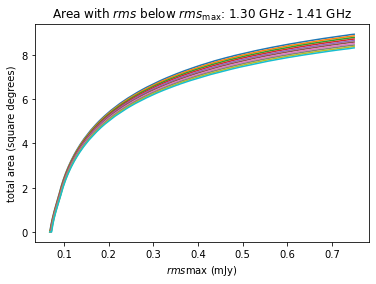

In [3]:
# Optionally calculate rms of a single pointing, optionally automatically generate mosaic
# Generate weight-, and rms-maps in fits format
# Calculate statistics on the generated maps and plot them
# according to specs above
ras, decs, names, hdu, rms, outstring = msc.genmos(locals())

In the plot showing pointing positions (white-outlined red dots), sensitivity (greyscale), and rms (contours):
   the assumed frequency is 1.40 GHz
   contours represent an rms noise of 0.05,0.10,0.20,0.40 mJy


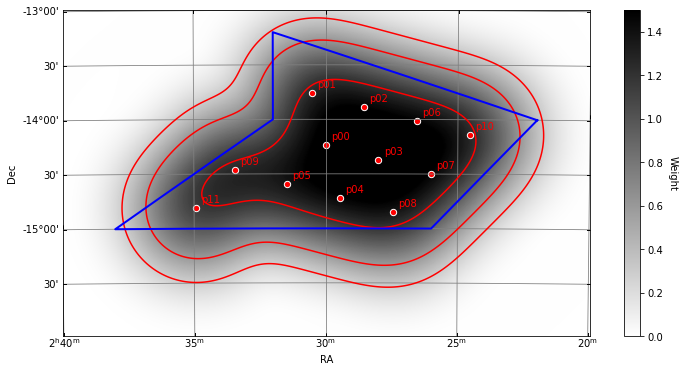

In [4]:
# Plot a map with pointings, weight map as a greyscale map, rms as contours, and optionally polygon
# according to specs above
outstring = msc.pltmos(locals(), cmap = 'gray_r', fontsize = 10)

In [5]:
# Print pointing positions
pointstring  = msc.prtmospos(locals())

Pointings:
p00: 02h30m00.00s -14d14m24.00s or 37.50000 -14.24000 (deg)
p01: 02h30m31.98s -13d45m25.18s or 37.63323 -13.75699 (deg)
p02: 02h28m32.59s -13d53m10.20s or 37.13580 -13.88617 (deg)
p03: 02h28m00.34s -14d22m08.01s or 37.00143 -14.36889 (deg)
p04: 02h29m27.89s -14d43m22.55s or 37.36620 -14.72293 (deg)
p05: 02h31m27.68s -14d35m35.80s or 37.86534 -14.59328 (deg)
p06: 02h26m33.07s -14d00m51.51s or 36.63779 -14.01431 (deg)
p07: 02h26m00.54s -14d29m48.30s or 36.50226 -14.49675 (deg)
p08: 02h27m27.95s -14d51m05.58s or 36.86645 -14.85155 (deg)
p09: 02h33m27.34s -14d27m45.34s or 38.36393 -14.46259 (deg)
p10: 02h24m33.40s -14d08m29.08s or 36.13916 -14.14141 (deg)
p11: 02h34m55.46s -14d48m52.42s or 38.73108 -14.81456 (deg)



In [6]:
# Dump (relevant) input into string
input_dump = msc.input_dump(locals())
 
# Generate pdf summary
msc.totsummary(locals())

Input:

rmssingle           = 'calculate'
t_int               = 16
Nant                = 60
velocity_width      = 5.513
obs_freq            = 1421000000.0
f_tap               = 1.0


RAmin               = 35.0
RAmax               = 40.0
Demin               = -16.0
Demax               = -13.0
numin               = 1300000000.0
numax               = 1400000000.0
cdeltxy             = 0.011
cdeltnu             = 10000000
ras                 = [37.5, 37.63323164920906, 37.135800290938406, 37.00143489742203, 37.366197090325926, 37.86534218746133, 36.63778864890436, 36.50225911630845, 36.86645018980546, 38.36392500783052, 36.1391573156895, 38.73108444185886]
decs                = [-14.239999999999995, -13.756994355247445, -13.88616795243995, -14.368892747545633, -14.722931461856158, -14.593278354048161, -14.014307263694999, -14.496751064051237, -14.851551219569894, -14.462593066016044, -14.141410952325224, -14.814561810442585]
names               = ['p00', 'p01', 'p02', 'p03', 'p04', 'p05', 